## dataload & FeatureEngineering

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno
import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')

def concat_and_export(train_fe, test_fe):
    
    train_fe['kind']='train'
    test_fe['kind']='test'
    
    df = pd.concat([train_fe,test_fe])
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/after_fe_train_test_cumsum.pkl'
    df.to_pickle(write_path,index=False)
    print(f"Write: {write_path}")
    
def export(df, output='after_fe_train_test.pkl'):
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/{output}'
    df.to_pickle(write_path)
    print(f"Write: {write_path}")
    
path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

def feature_engineering(df):
    uid2idx = {v:k for k,v in enumerate(sorted(df.userID.unique()))}
    ass2idx = {v:k for k,v in enumerate(sorted(df.assessmentItemID.unique()))}
    test2idx = {v:k for k,v in enumerate(sorted(df.testId.unique()))}

    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # userID, assessmentItemID, testId 라벨인코딩
    df2['uidIdx'] = df2.userID.map(uid2idx)
    df2['assIdx'] = df2.assessmentItemID.map(ass2idx)
    df2['testIdx'] = df2.testId.map(test2idx)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    # 유저별 문제푼 시간, solvesec_3600, time_category
    df2['Timestamp2'] = pd.to_datetime(df2.Timestamp)
    df2['solvetime'] = df2.groupby('userID')['Timestamp2'].diff().fillna(pd.Timedelta(seconds=0))
    df2['solvesec'] = df2.solvetime.map(lambda x : x.total_seconds())
    df2['solvesec_3600'] = df2.solvesec
    df2.loc[df2.solvesec>=3600,'solvesec_3600']=3600

    df2['time_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600]
    df2.loc[(df2.solvesec==0), 'time_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec>s) & (df2.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
    timecat2idx={k:v for v,k in enumerate(sorted(df2.time_category.unique()))}
    df2['time_category'] = df2.time_category.map(timecat2idx)
    
    # Cumsum
    df2['solvesec_cumsum'] = df2.groupby(['userID','testId'])['solvesec_3600'].cumsum()%3601
    df2['solvecumsum_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600,7200]
    df2.loc[(df2.solvesec_cumsum==0), 'solvecumsum_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec_cumsum>s) & (df2.solvesec_cumsum<=e),'solvecumsum_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec_cumsum>=tc[-1]),'solvecumsum_category'] = f"{i+2} - ({e}, )"
    solvecumsum_category2idx={k:v for v,k in enumerate(sorted(df2.solvecumsum_category.unique()))}
    df2['solvecumsum_category'] = df2.solvecumsum_category.map(solvecumsum_category2idx)
    return df2

train['kind']='train'
test['kind']='test'
df = pd.concat([train,test])
df = feature_engineering(df)

In [7]:
df[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,tag_mean,tag_std,tag_sum,Timestamp2,solvetime,solvesec,solvesec_3600,time_category,solvesec_cumsum,solvecumsum_category
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,train,0,5354,975,...,0.957333,0.202239,718,2020-03-24 00:17:11,0 days 00:00:00,0.0,0.0,0,0.0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,train,0,5355,975,...,0.917067,0.275818,3439,2020-03-24 00:17:14,0 days 00:00:03,3.0,3.0,1,3.0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,train,0,5356,975,...,0.917067,0.275818,3439,2020-03-24 00:17:22,0 days 00:00:08,8.0,8.0,3,11.0,4


In [9]:
import time
df['Time'] = df['Timestamp2'].apply(lambda x: int(time.mktime(x.timetuple())))

In [10]:
def assess_count(data):
    data['cnt'] = 1
    data['assess_count'] = data.groupby(['userID', 'assessmentItemID'])['cnt'].cumsum()
    return data.drop(columns = 'cnt')
    
def timepass(data : pd.DataFrame):
    timepassed = [0]
    for i in range(1, data.shape[0]) :
        if (data.loc[i-1,'testId'] != data.loc[i,'testId']) | (data.loc[i-1,'userID'] != data.loc[i,'userID'])\
             | (data.loc[i-1,'assess_count'] != data.loc[i,'assess_count']):
            timepassed.append(0)
        else :
            timepassed.append(data.loc[i,'Time'] - data.loc[i-1,'Time'])
    return np.array(timepassed)

In [ ]:
assess_count(df)

In [13]:
timediff = timepass(df)
df['Timediff'] = timediff

In [14]:
df['Timepassed'] = df.groupby(['userID','testId','assess_count'])['Timediff'].cumsum()

In [22]:
df[df.answerCode==1].Timepassed.describe()

count    1.653588e+06
mean     4.379673e+02
std      8.377838e+03
min      0.000000e+00
25%      1.300000e+01
50%      7.100000e+01
75%      2.020000e+02
max      1.809063e+06
Name: Timepassed, dtype: float64

In [24]:
df[:10]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,solvesec,solvesec_3600,time_category,solvesec_cumsum,solvecumsum_category,Time,cnt,assess_count,Timediff,Timepassed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,train,0,5354,975,...,0.0,0.0,0,0.0,0,1584976631,1,1,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,train,0,5355,975,...,3.0,3.0,1,3.0,1,1584976634,1,1,3,3
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,train,0,5356,975,...,8.0,8.0,3,11.0,4,1584976642,1,1,8,11
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,train,0,5357,975,...,7.0,7.0,2,18.0,4,1584976649,1,1,7,18
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,train,0,5358,975,...,7.0,7.0,2,25.0,4,1584976656,1,1,7,25
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,train,0,5359,975,...,11.0,11.0,4,36.0,4,1584976667,1,1,11,36
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,train,0,5367,977,...,192856.0,3600.0,9,3600.0,8,1585169523,1,1,0,0
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,train,0,5368,977,...,7.0,7.0,2,6.0,2,1585169530,1,1,7,7
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,train,0,5369,977,...,64.0,64.0,5,70.0,5,1585169594,1,1,64,71
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,train,0,5370,977,...,15.0,15.0,4,85.0,5,1585169609,1,1,15,86


<AxesSubplot:ylabel='Density'>

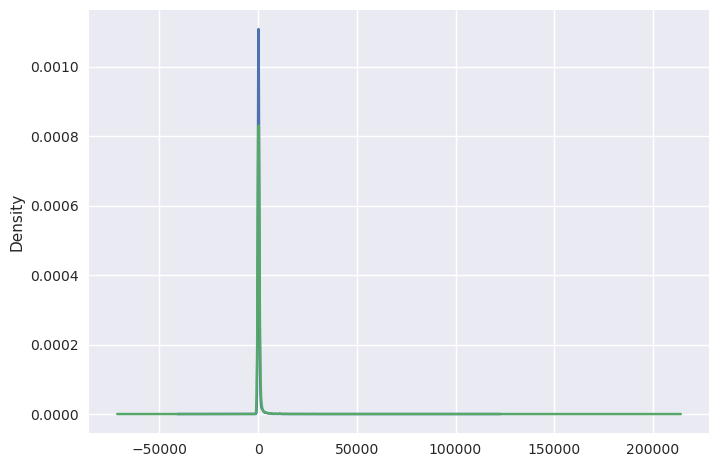

In [32]:
df[df.answerCode==1].groupby('userID').Timepassed.mean().plot(kind='kde')
q=df[df.answerCode==0].groupby('userID').Timepassed.mean().plot(kind='kde')

## 내보내기

In [33]:
df2 = df.copy()
export(df2, output='after_fe_train_test_timepass.pkl')

Write: /opt/ml/input/data/after_fe_train_test_timepass.pkl
